In [7]:
import torch
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [8]:
class NOHThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path  # Define the base path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the relative image path from the dataframe and append it to the base path
        image_path = os.path.join(self.base_path, self.dataframe['image_path'][idx].replace("\\", "/"))
        label = self.dataframe['Surgery diagnosis in number'][idx]

        # Open the image
        image = Image.open(image_path)

        # Apply any transformation (if available)
        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
import torchvision.transforms as v2
import torch.nn as nn

# Define the transformations for training and testing
train_transform = v2.Compose([
    v2.Resize(320),  # Resize the image to match EfficientNet input size
    v2.RandomCrop(320),  
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization
])

test_transform = v2.Compose([
    v2.Resize(320),  
    v2.CenterCrop(320),  
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [16]:
import torch
from efficientnet_pytorch import EfficientNet

# Load EfficientNet without the classification head
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = torch.nn.Identity()  # Remove the classification head

def extract_features(image, model):
    """
    Extract features from the image using the EfficientNet model
    without the classification head.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        image = image.unsqueeze(0)  # Add batch dimension (1, 3, 320, 320)
        features = model(image)  # Extract feature vector
        features = features.view(features.size(0), -1)  # Flatten the features
    return features.squeeze().numpy()


Loaded pretrained weights for efficientnet-b0


In [32]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # This forces PIL to load truncated images

def create_feature_label_loader(dataset, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_features = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc="Extracting Features"):
        batch_features = []
        for image in images:
            try:
                # Extract features
                features = extract_features(image, model)
                batch_features.append(features)
            except OSError as e:
                print(f"Error processing image: {e}. Skipping.")
                continue
        
        all_features.extend(batch_features)
        all_labels.extend(labels.numpy())
    
    return np.array(all_features), np.array(all_labels)


In [33]:
# Load the dataset from a CSV file
df = pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/data_NOH_V2.csv')

# Define the base path for images
base_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/'

# Initialize the dataset
dataset = NOHThyroidDataset(dataframe=df, base_path=base_path, transform=train_transform)


In [34]:
features, labels = create_feature_label_loader(dataset, batch_size=32)


Extracting Features: 100%|██████████| 64/64 [02:31<00:00,  2.37s/it]


In [ ]:
from sklearn.model_selection import GridSearchCV

# Set the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)


AUC: 0.86
Precision: 0.88
F1 Score: 0.93
Accuracy: 0.89


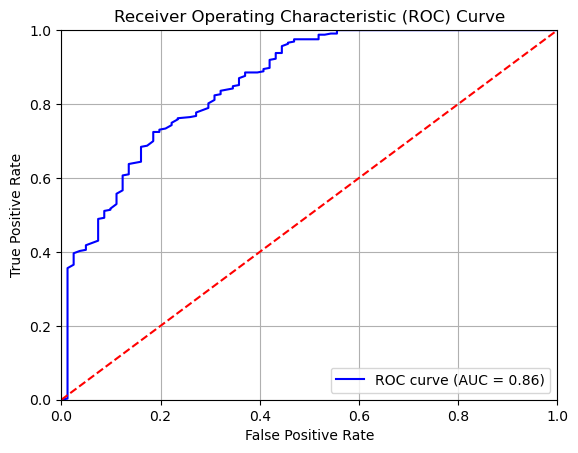

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_score,
    f1_score,
    ConfusionMatrixDisplay,
    accuracy_score
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Get predicted probabilities for the positive class
y_prob = rf.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate metrics
auc = roc_auc_score(y_test, y_prob)
y_pred = rf.predict(X_test)  # Class predictions
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the metrics
print(f"AUC: {auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [37]:
from sklearn.model_selection import cross_val_score

# Initialize Random Forest with optimal parameters from grid search
optimized_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(optimized_rf, features, labels, cv=5, scoring='roc_auc')

print(f'Average Cross-Validation AUC: {cv_scores.mean():.2f}')


Average Cross-Validation AUC: 0.75
